In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from IPython.core.display import display, HTML
import time
import folium

ModuleNotFoundError: No module named 'geopy'

In [2]:
pip install geopy


In [3]:
!pip install geopy


In [7]:
zomato_df = pd.read_csv("C:\\Users\\pc\\Downloads\\zomato_data.csv")
geo_df = pd.read_csv("C:\\Users\\pc\\Downloads\\Geographical_Coordinates.csv")


In [8]:
print(zomato_df.info())
print(zomato_df.isnull().sum())
print(zomato_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   online_order               51717 non-null  object
 1   book_table                 51717 non-null  object
 2   rate                       43942 non-null  object
 3   votes                      51717 non-null  int64 
 4   rest_type                  51490 non-null  object
 5   dish_liked                 23639 non-null  object
 6   cuisines                   51672 non-null  object
 7   approx_costfor_two_people  51371 non-null  object
 8   listed_intype              51717 non-null  object
 9   listed_incity              51717 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.9+ MB
None
online_order                     0
book_table                       0
rate                          7775
votes                            0
rest_type                      227
d

In [9]:
print(geo_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   listed_incity  26 non-null     object 
 1   Latitude       26 non-null     float64
 2   Longitude      26 non-null     float64
dtypes: float64(2), object(1)
memory usage: 756.0+ bytes
None


In [11]:
zomato_df['rate'] = zomato_df['rate'].replace('-', np.nan)


In [14]:
zomato_df['rate'] = zomato_df['rate'].astype(str).replace('nan', np.nan)  # Convert to string, handle NaN
zomato_df['rate'] = zomato_df['rate'].str.replace('/5', '', regex=False)  # Replace '/5'
zomato_df['rate'] = pd.to_numeric(zomato_df['rate'], errors='coerce')     # Convert back to numeric
zomato_df['rate'] = zomato_df['rate'].fillna(zomato_df['rate'].median())  # Fill NaN with median


In [16]:
# Step 1: Remove commas and convert to numeric
zomato_df['approx_costfor_two_people'] = pd.to_numeric(
    zomato_df['approx_costfor_two_people'].astype(str).str.replace(',', ''), errors='coerce'
)

# Step 2: Fill missing values with median
zomato_df['approx_costfor_two_people'] = zomato_df['approx_costfor_two_people'].fillna(zomato_df['approx_costfor_two_people'].median())


In [18]:
zomato_df['dish_liked'] = zomato_df['dish_liked'].fillna("Not Available")
zomato_df['cuisines'] = zomato_df['cuisines'].fillna("Other")
zomato_df['rest_type'] = zomato_df['rest_type'].fillna("Unknown")


In [20]:
zomato_df['votes'] = zomato_df['votes'].fillna(zomato_df['votes'].median())


In [21]:
zomato_df['online_order'] = zomato_df['online_order'].map({'Yes': 1, 'No': 0})
zomato_df['book_table'] = zomato_df['book_table'].map({'Yes': 1, 'No': 0})

In [22]:
zomato_df['rate'] = zomato_df['rate'].astype(float)
zomato_df['votes'] = zomato_df['votes'].astype(int)
zomato_df['approx_costfor_two_people'] = zomato_df['approx_costfor_two_people'].astype(int)

In [23]:
merged_df = pd.merge(zomato_df, geo_df, on='listed_incity', how='left')
print(merged_df.head())

   online_order  book_table  rate  votes            rest_type  \
0             1           1   4.1    775        Casual Dining   
1             1           0   4.1    787        Casual Dining   
2             1           0   3.8    918  Cafe, Casual Dining   
3             0           0   3.7     88          Quick Bites   
4             0           0   3.8    166        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines  approx_costfor_two_people listed_intype  \
0  North Indian, Mughlai, Chinese                        800        Buffet   
1     Chinese, North Indian, Thai                        800        Buffet   
2          Cafe, Mexican, Italian     

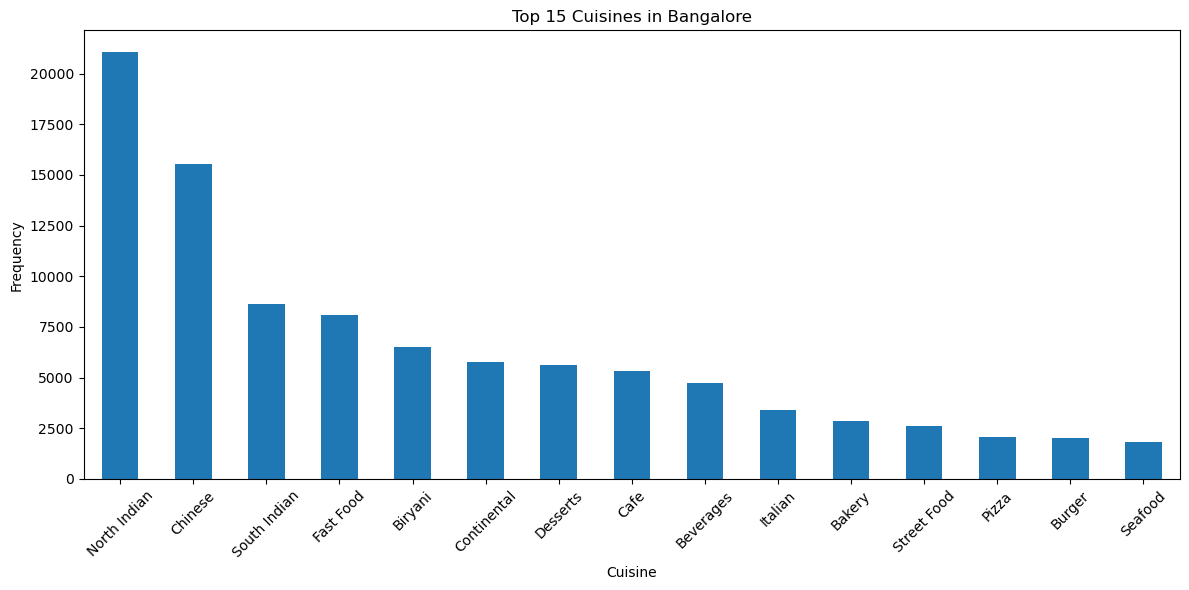

In [24]:
plt.figure(figsize=(12,6))
merged_df['cuisines'].str.split(',').explode().str.strip().value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Cuisines in Bangalore")
plt.xlabel("Cuisine")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

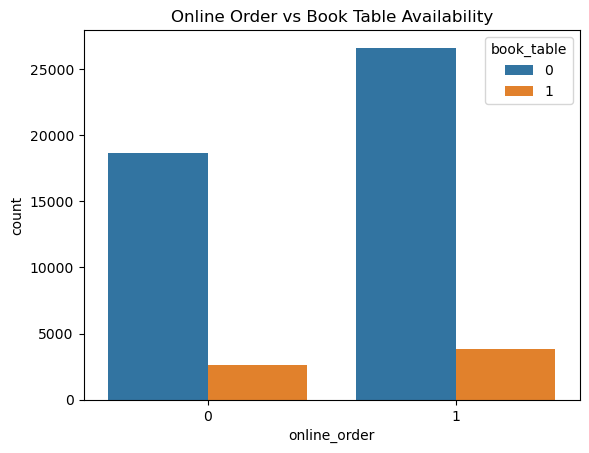

In [25]:
sns.countplot(data=merged_df, x='online_order', hue='book_table')
plt.title("Online Order vs Book Table Availability")
plt.show()

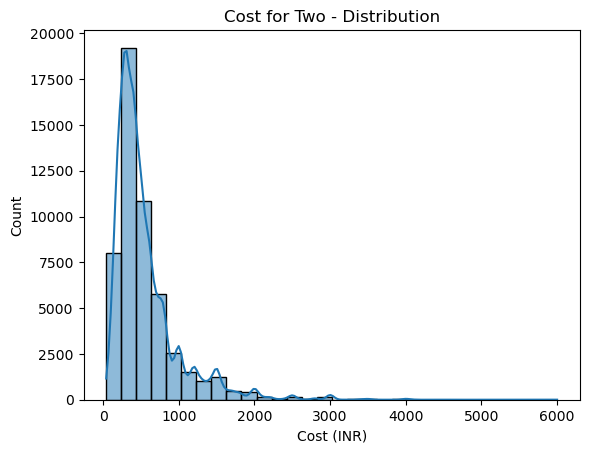

In [26]:
sns.histplot(merged_df['approx_costfor_two_people'], bins=30, kde=True)
plt.title("Cost for Two - Distribution")
plt.xlabel("Cost (INR)")
plt.show()

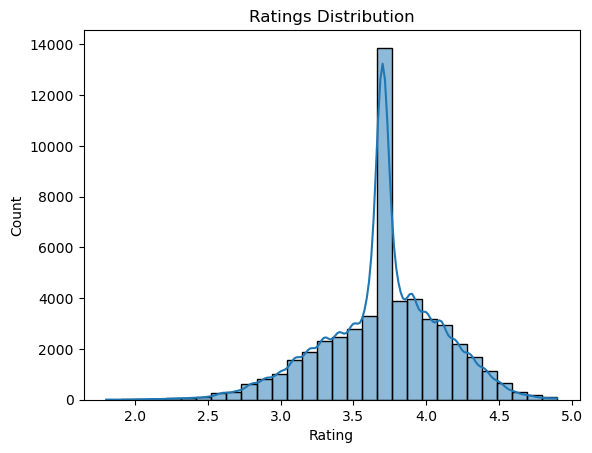

In [27]:
sns.histplot(merged_df['rate'], bins=30, kde=True)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.show()

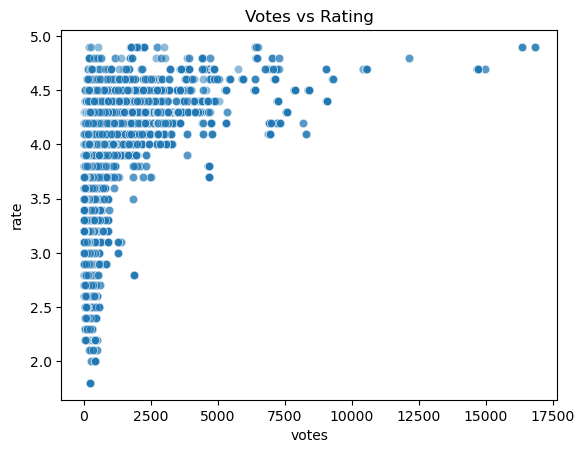

In [28]:
sns.scatterplot(data=merged_df, x='votes', y='rate', alpha=0.5)
plt.title("Votes vs Rating")
plt.show()

In [32]:
map_density = folium.Map(location=[12.9716, 77.5946], zoom_start=12)
for _, row in merged_df.iterrows():
    if not np.isnan(row['Latitude']) and not np.isnan(row['Longitude']):
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=2,
            color='blue',
            fill=True,
            fill_opacity=0.4
        ).add_to(map_density)
map_density.save("restaurant_density_map.html")

NameError: name 'folium' is not defined

In [31]:
!pip install folium




In [33]:
import folium


In [35]:
map_density = folium.Map(location=[12.9716, 77.5946], zoom_start=12)
for _, row in merged_df.iterrows():
    if not np.isnan(row['Latitude']) and not np.isnan(row['Longitude']):
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=2,
            color='blue',
            fill=True,
            fill_opacity=0.4
        ).add_to(map_density)
map_density.save("restaurant_density_map.html")

In [36]:
italian_df = merged_df[merged_df['cuisines'].str.contains('Italian', case=False, na=False)]
map_italian = folium.Map(location=[12.9716, 77.5946], zoom_start=12)
for _, row in italian_df.iterrows():
    if not np.isnan(row['Latitude']) and not np.isnan(row['Longitude']):
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['cuisines']
        ).add_to(map_italian)
map_italian.save("italian_restaurants_map.html")